In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
from datetime import datetime
from regions import PolygonSkyRegion
import dkist
from iris_spec_recon import iris_spec_map_interp_from_header
from fancy_colorbar import plot_colorbar
from matplotlib import ticker

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


In [2]:
vbi_hmi_xshift, vbi_hmi_yshift = 4.40*u.arcsec, 1.46*u.arcsec

dkist_vbi_target_map = sunpy.map.Map('../../src/DKIST/vbi_1024/BJOLO/VBI_2022_10_24T18_59_13_686_00486136_I_BJOLO_L1.fits')
dkist_vbi_target_map = dkist_vbi_target_map.shift_reference_coord(vbi_hmi_xshift,vbi_hmi_yshift)
dkist_vbi_target_map.meta['rsun_ref'] = 696000000.0
vbi_target_wcs = dkist_vbi_target_map.wcs[257:-256:4,257:-256:4]

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


In [3]:
iris_SiIV_1394_velmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vel_map.fits")
Txshift_iris_aia_2322, Tyshift_iris_aia_2322 = -0.0271646*u.arcsec, -0.048959*u.arcsec
iris_SiIV_1394_velmap_rotate = iris_SiIV_1394_velmap.rotate()
iris_SiIV_1394_velmap_rotate_shift = iris_SiIV_1394_velmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

iris_SiIV_1394_intmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_int_map.fits")
iris_SiIV_1394_intmap_rotate = iris_SiIV_1394_intmap.rotate()
iris_SiIV_1394_intmap_rotate_shift = iris_SiIV_1394_intmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

iris_SiIV_1394_vnthmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vnth_map.fits")
iris_SiIV_1394_vnthmap_rotate = iris_SiIV_1394_vnthmap.rotate()
iris_SiIV_1394_vnthmap_rotate_shift = iris_SiIV_1394_vnthmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


In [4]:
iris_CII_velmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/CII_vel_map.fits")
iris_CII_velmap_rotate = iris_CII_velmap.rotate()
iris_CII_velmap_rotate_shift = iris_CII_velmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]


In [5]:
iris2model = readsav('../../src/IRIS/20221024/2322/iris2model_20221024_232249_3600609177_raster_t000_r00000.sav',verbose=True)['iris2model'][0]
ltau = iris2model["ltau"]
atmos = iris2model["model"]
Te, vlos, vturb, Ne = atmos

Te_interp, irisspec_wcs = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                                                          data=Te.transpose(1,2,0),win_ext=6)
Ne_interp, irisspec_wcs = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                                                          data=Ne.transpose(1,2,0),win_ext=6)
vlos_interp, irisspec_wcs = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                                                          data=vlos.transpose(1,2,0),win_ext=6)
vturb_interp, irisspec_wcs = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                                                          data=vturb.transpose(1,2,0),win_ext=6)


--------------------------------------------------
Date: Wed Apr 17 18:38:31 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 4 records of which:
 - 1 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - iris2model [<class 'numpy.recarray'>]
--------------------------------------------------


In [6]:
iris2_MgII_k_dopplergram = readsav('../../src/IRIS/20221024/2322/MgII_k_Dopplergram_pn50_20221024_232249_3600609177_raster_t000_r00000.sav')['doppgr']
iris2_MgII_k_dopplergram = np.flip(iris2_MgII_k_dopplergram,axis=1)

In [7]:
iris2_MgII_k_dopplergram_map = iris_spec_map_interp_from_header("../../src/IRIS/20221024/2322/iris_l2_20221024_232249_3600609177_raster_t000_r00000.fits",
                                                          data=iris2_MgII_k_dopplergram,win_ext=6)    

In [8]:
ltau_aver_index = np.where((ltau >= - 4.61) & (ltau <= -4.19))[0]

Te_map = sunpy.map.Map(np.nanmean(Te_interp[:,:,ltau_aver_index],axis=-1),irisspec_wcs)
Ne_map = sunpy.map.Map(np.nanmean(Ne_interp[:,:,ltau_aver_index],axis=-1),irisspec_wcs)
vlos_map = sunpy.map.Map(np.nanmean(vlos_interp[:,:,ltau_aver_index]/1e5,axis=-1),irisspec_wcs)
vturb_map = sunpy.map.Map(np.nanmean(vturb_interp[:,:,ltau_aver_index]/1e5,axis=-1),irisspec_wcs)

/tmp/ipykernel_2566542/223147566.py:3: RuntimeWarning: Mean of empty slice
  Te_map = sunpy.map.Map(np.nanmean(Te_interp[:,:,ltau_aver_index],axis=-1),irisspec_wcs)
/tmp/ipykernel_2566542/223147566.py:4: RuntimeWarning: Mean of empty slice
  Ne_map = sunpy.map.Map(np.nanmean(Ne_interp[:,:,ltau_aver_index],axis=-1),irisspec_wcs)
/tmp/ipykernel_2566542/223147566.py:5: RuntimeWarning: Mean of empty slice
  vlos_map = sunpy.map.Map(np.nanmean(vlos_interp[:,:,ltau_aver_index]/1e5,axis=-1),irisspec_wcs)
/tmp/ipykernel_2566542/223147566.py:6: RuntimeWarning: Mean of empty slice
  vturb_map = sunpy.map.Map(np.nanmean(vturb_interp[:,:,ltau_aver_index]/1e5,axis=-1),irisspec_wcs)


In [9]:
with propagate_with_solar_surface():
    iris_SiIV_1394_intmap_to_vbi = iris_SiIV_1394_intmap_rotate_shift.reproject_to(vbi_target_wcs, 
                                                                                   algorithm='adaptive',)
    iris_SiIV_1394_velmap_to_vbi = iris_SiIV_1394_velmap_rotate_shift.reproject_to(vbi_target_wcs)
    iris_SiIV_1394_vnthmap_to_vbi = iris_SiIV_1394_vnthmap_rotate_shift.reproject_to(vbi_target_wcs)
    
    iris_CII_velmap_to_vbi = iris_CII_velmap_rotate_shift.reproject_to(vbi_target_wcs)

    Te_to_vbi = Te_map.reproject_to(vbi_target_wcs)
    Ne_to_vbi = Ne_map.reproject_to(vbi_target_wcs)
    vlos_to_vbi = vlos_map.reproject_to(vbi_target_wcs,)
    vturb_to_vbi = vturb_map.reproject_to(vbi_target_wcs)

    iris2_MgII_k_dopplergram_map_to_vbi = iris2_MgII_k_dopplergram_map.reproject_to(vbi_target_wcs, algorithm='adaptive')

    

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crlt_obs,crln_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington

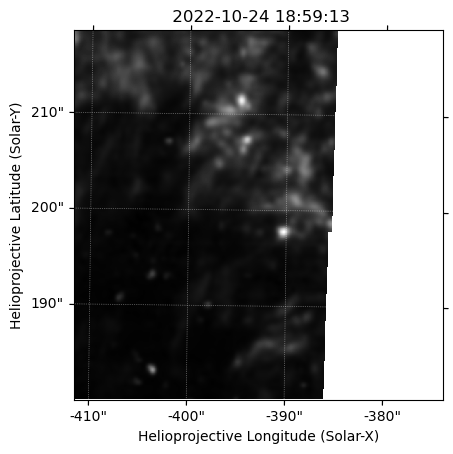

In [10]:
iris_SiIV_1394_intmap_to_vbi.plot()

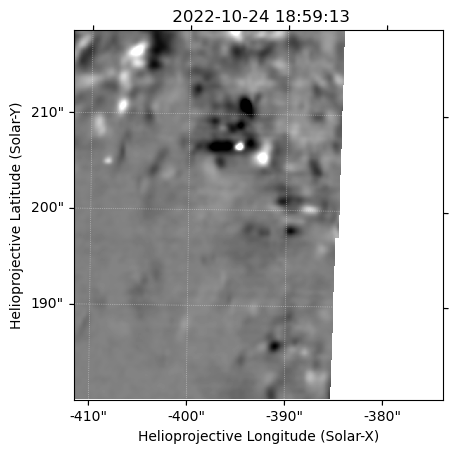

In [11]:
iris2_MgII_k_dopplergram_map_to_vbi.plot(vmin=-100, vmax=100,)

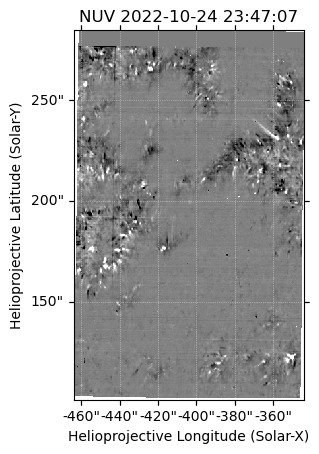

In [12]:
iris2_MgII_k_dopplergram_map.plot(vmin=-100, vmax=100,)

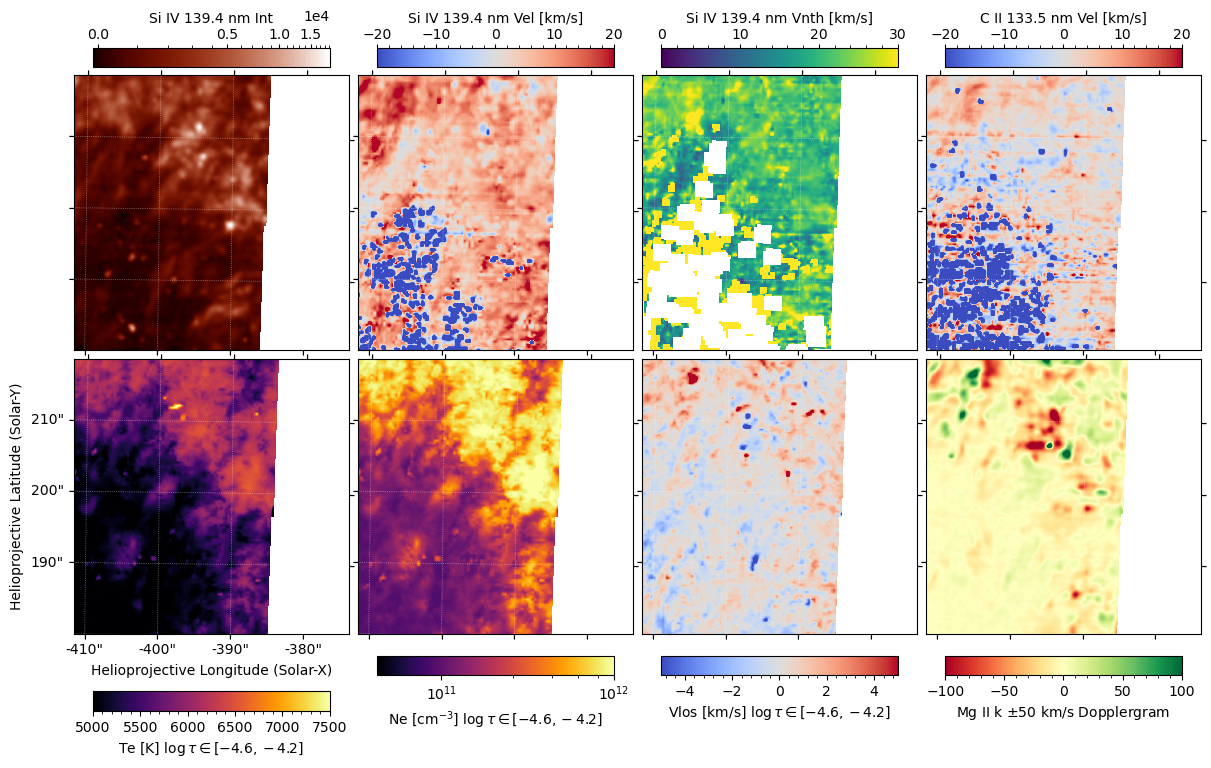

In [13]:
fig = plt.figure(figsize=(12,7.5),layout='constrained')

ax1 = fig.add_subplot(241,projection=iris_SiIV_1394_intmap_to_vbi)
im1 = iris_SiIV_1394_intmap_to_vbi.plot(axes=ax1,title=None,
                                cmap='irissji1400', norm=ImageNormalize(stretch=AsinhStretch(0.1)))

ax2 = fig.add_subplot(242,projection=iris_SiIV_1394_velmap_to_vbi)
im2 = iris_SiIV_1394_velmap_to_vbi.plot(axes=ax2,title=None,
                                cmap='coolwarm', norm=ImageNormalize(vmin=-20, vmax=20))

ax3 = fig.add_subplot(243,projection=iris_SiIV_1394_vnthmap_to_vbi)
im3 = iris_SiIV_1394_vnthmap_to_vbi.plot(axes=ax3,title=None,
                                cmap='viridis', norm=ImageNormalize(vmin=0, vmax=30))

ax4 = fig.add_subplot(244,projection=iris_CII_velmap_to_vbi)
im4 = iris_CII_velmap_to_vbi.plot(axes=ax4,title=None,
                                cmap='coolwarm', norm=ImageNormalize(vmin=-20, vmax=20))

ax5 = fig.add_subplot(245,projection=Te_to_vbi)
im5 = Te_to_vbi.plot(axes=ax5,title=None,
            cmap='inferno', norm=ImageNormalize(vmin=5000, vmax=7.5e3))

ax6 = fig.add_subplot(246,projection=Ne_to_vbi)
im6 = Ne_to_vbi.plot(axes=ax6,title=None,
            cmap='inferno', norm=ImageNormalize(vmin=1e10, vmax=1e12, stretch=AsinhStretch(0.1)))

ax7 = fig.add_subplot(247,projection=vlos_to_vbi)
im7 = vlos_to_vbi.plot(axes=ax7,title=None,
            cmap='coolwarm', norm=ImageNormalize(vmin=-5, vmax=5))

ax8 = fig.add_subplot(248,projection=iris2_MgII_k_dopplergram_map_to_vbi)
im8 = iris2_MgII_k_dopplergram_map_to_vbi.plot(axes=ax8,title=None,
                                cmap='RdYlGn', norm=ImageNormalize(vmin=-100, vmax=100))


clb1, clb_ax1 = plot_colorbar(im1, ax1,
                                bbox_to_anchor=(0.07,1.03,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax1.set_xlabel('Si IV 139.4 nm Int', fontsize=10)

clb2, clb_ax2 = plot_colorbar(im2, ax2,
                                bbox_to_anchor=(0.07,1.03,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax2.set_xlabel('Si IV 139.4 nm Vel [km/s]', fontsize=10)

clb3, clb_ax3 = plot_colorbar(im3, ax3,
                                bbox_to_anchor=(0.07,1.03,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax3.set_xlabel('Si IV 139.4 nm Vnth [km/s]', fontsize=10)

clb4, clb_ax4 = plot_colorbar(im4, ax4,
                                bbox_to_anchor=(0.07,1.03,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax4.set_xlabel('C II 133.5 nm Vel [km/s]', fontsize=10)

for clb_ax_ in (clb_ax1,clb_ax2,clb_ax3,clb_ax4):
    clb_ax_.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False,
                        length=3)
    clb_ax_.xaxis.tick_top()
    clb_ax_.xaxis.set_label_position('top') 
    clb_ax_.tick_params(which="major", pad=1)

clb5, clb_ax5 = plot_colorbar(im5, ax5,
                                bbox_to_anchor=(0.07,-0.28,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,4),)

clb_ax5.set_xlabel(r'Te [K] $\log \tau \in [-4.6,-4.2]$', fontsize=10)

clb6, clb_ax6 = plot_colorbar(im6, ax6,
                                bbox_to_anchor=(0.07,-0.15,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax6.set_xlabel(r'Ne [cm$^{-3}$] $\log \tau \in [-4.6,-4.2]$', fontsize=10)
clb_ax6.set_xticks([1e11,1e12])
clb_ax6.xaxis.set_major_formatter(ticker.LogFormatterSciNotation())

clb7, clb_ax7 = plot_colorbar(im7, ax7,
                                bbox_to_anchor=(0.07,-0.15,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,2),)

clb_ax7.set_xlabel(r'Vlos [km/s] $\log \tau \in [-4.6,-4.2]$', fontsize=10)

clb8, clb_ax8 = plot_colorbar(im8, ax8,
                                bbox_to_anchor=(0.07,-0.15,0.86,0.07), orientation='horizontal',
                                fontsize=10,scilimits=(-2,4),)

clb_ax8.set_xlabel(r'Mg II k $\pm50$ km/s Dopplergram', fontsize=10)






for ax_ in (ax1,ax2,ax3,ax4,ax6,ax7,ax8):
    # ax_.coords[0].set_ticks_visible(False)
    # ax_.coords[1].set_ticks_visible(False)
    ax_.coords[0].set_ticklabel_visible(False)
    ax_.coords[1].set_ticklabel_visible(False)
    ax_.coords[0].axislabels.set_visible(False)
    ax_.coords[1].axislabels.set_visible(False)

In [76]:
with propagate_with_solar_surface():
    example_pixel_vbi_skycoord = SkyCoord(-390*u.arcsec, 200*u.arcsec, frame=iris_SiIV_1394_intmap_to_vbi.coordinate_frame)
    example_pixel_iris2 = Te_map.wcs.world_to_pixel(example_pixel_vbi_skycoord)
    example_pixel_iris2 = np.round(example_pixel_iris2).astype(int)

example_iris2_Te_profile = Te_interp[example_pixel_iris2[1],example_pixel_iris2[0],:]
example_iris2_Ne_profile = Ne_interp[example_pixel_iris2[1],example_pixel_iris2[0],:]
example_iris2_vlos_profile = vlos_interp[example_pixel_iris2[1],example_pixel_iris2[0],:]
example_iris2_vturb_profile = vturb_interp[example_pixel_iris2[1],example_pixel_iris2[0],:]

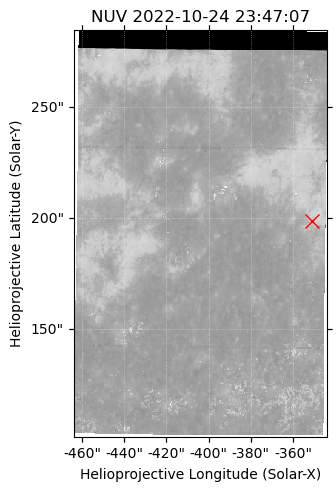

In [77]:
fig = plt.figure(layout='constrained')
ax = fig.add_subplot(111, projection=Te_map)
Te_map.plot(axes=ax)
ax.plot(example_pixel_iris2[0], example_pixel_iris2[1], 'x', color='red', markersize=10)

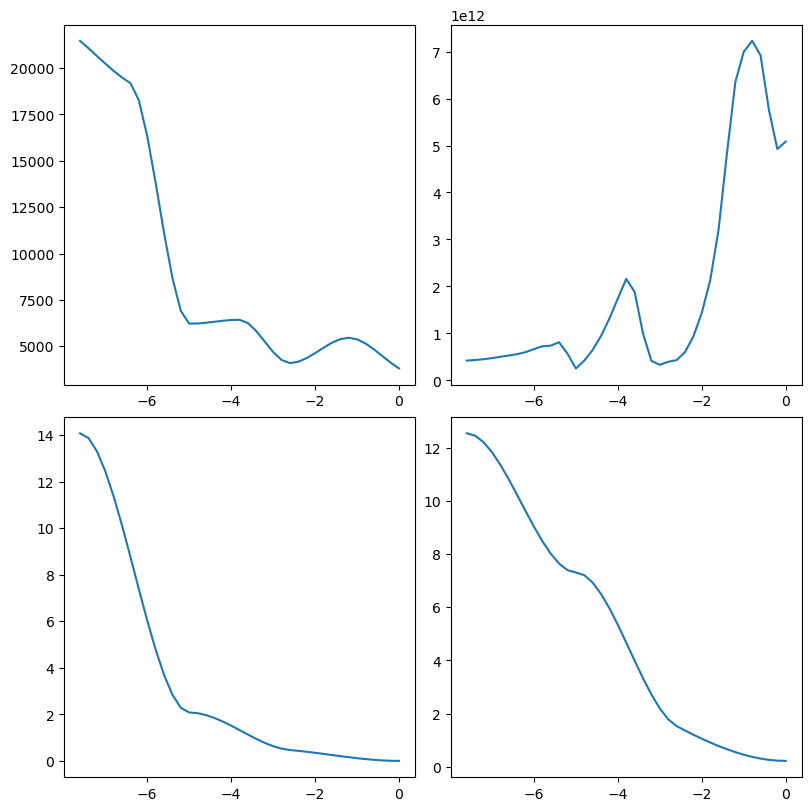

In [78]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8),layout='constrained')

ax1.plot(ltau, example_iris2_Te_profile)
ax2.plot(ltau, example_iris2_Ne_profile)
ax3.plot(ltau, example_iris2_vlos_profile/1e5)
ax4.plot(ltau, example_iris2_vturb_profile/1e5)